In [98]:
import pandas as pd
import numpy as np
import talib as ta

df = pd.read_csv("data.csv")
df

,Unnamed: 0,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,0,601398.SH,20240308,5.3700,5.4000,5.3400,5.3900,5.38,0.0100,0.1859,2472003.99,1328152.980
1,1,601398.SH,20240307,5.3500,5.4000,5.3400,5.3800,5.35,0.0300,0.5607,3074594.09,1650760.690
2,2,601398.SH,20240306,5.4500,5.4900,5.3500,5.3500,5.46,-0.1100,-2.0147,3527871.55,1910626.811
3,3,601398.SH,20240305,5.3200,5.4800,5.3000,5.4600,5.32,0.1400,2.6316,4298467.12,2323265.996
4,4,601398.SH,20240304,5.3200,5.3400,5.2800,5.3200,5.34,-0.0200,-0.3745,2557572.75,1359409.110
...,...,...,...,...,...,...,...,...,...,...,...,...
522,522,601398.SH,20220110,4.1782,4.1959,4.1606,4.1871,4.74,-0.5529,-11.6646,1583293.03,750737.778
523,523,601398.SH,20220107,4.1342,4.1871,4.1253,4.1782,4.70,-0.5218,-11.1021,1939649.55,916673.916
524,524,601398.SH,20220106,4.1430,4.1694,4.1253,4.1430,4.71,-0.5670,-12.0382,1903143.59,894943.768
525,525,601398.SH,20220105,4.1077,4.1606,4.0989,4.1518,4.67,-0.5182,-11.0964,2839546.21,1332859.587


In [99]:
df = df.sort_values(by="trade_date", ascending=True)
df = df[["trade_date", "open", "high", "low", "close", "vol"]]
df = df.rename(columns={"vol": "volume"})
df = df.set_index("trade_date")
df.index = pd.to_datetime(df.index, format=r"%Y%m%d")
df.sort_index(inplace=True)
df

,open,high,low,close,volume
trade_date,,,,,
2022-01-04,4.0901,4.1165,4.0813,4.1165,1688756.35
2022-01-05,4.1077,4.1606,4.0989,4.1518,2839546.21
2022-01-06,4.1430,4.1694,4.1253,4.1430,1903143.59
2022-01-07,4.1342,4.1871,4.1253,4.1782,1939649.55
2022-01-10,4.1782,4.1959,4.1606,4.1871,1583293.03
...,...,...,...,...,...
2024-03-04,5.3200,5.3400,5.2800,5.3200,2557572.75
2024-03-05,5.3200,5.4800,5.3000,5.4600,4298467.12
2024-03-06,5.4500,5.4900,5.3500,5.3500,3527871.55


In [100]:
multipier = 1
period = 4

# REF: https://www.quantifiedstrategies.com/supertrend-indicator-trading-strategy/
# REF: https://www.investopedia.com/terms/a/atr.asp
# # TRANGE(high, low, close) Average True Range
df["TR"] = ta.TRANGE(df["high"].values, df["low"].values, df["close"].values)
df["ATR"] = ta.SMA(df["TR"], period) # or df["TR"].rolling(window=period).mean()

# 计算basic趋势线 (High + Low) / 2 + Multiplier * ATR
df["basic-ub"] = (df["high"] + df["low"]) / 2 + multipier * df["ATR"]
df["basic-lb"] = (df["high"] + df["low"]) / 2 - multipier * df["ATR"]

# 计算final趋势线
df['final-ub'] = 0.00
df['final-lb'] = 0.00

for i in range(period, len(df)):
    # 逐行遍历 根据basic计算final
    # 上趋势线只允许相等或者降低 除非上趋势线被突破了
    df['final-ub'].iat[i] = df['basic-ub'].iat[i] \
                            if df['basic-ub'].iat[i] < df['final-ub'].iat[i-1] or df['close'].iat[i-1] > df['final-ub'].iat[i-1] \
                            else df['final-ub'].iat[i-1]

    df['final-lb'].iat[i] = df['basic-lb'].iat[i] \
                            if df['basic-lb'].iat[i] > df['final-lb'].iat[i-1] or df['close'].iat[i-1] < df['final-lb'].iat[i-1] \
                            else df['final-lb'].iat[i-1]

df["st"] = 0.0
for i in range(period, len(df)):
    # 突破上趋势线的时候 st采用下趋势线做支撑
    # 当先前st处于上趋势线 且 close <=上趋势线 st采用上趋势线
    # 当先前st处于上趋势线 且 close > 上趋势线 st采用下趋势线
    # 当先前st处于下趋势线 且 close >=下趋势线 st采用下趋势线
    # 当先前st处于下趋势线 且 close < 下趋势线 st采用上趋势线
    df["st"].iat[i] = df["final-ub"].iat[i] if df["st"].iat[i-1] == df["final-ub"].iat[i-1] and df["close"].iat[i] <= df["final-ub"].iat[i] else \
                      df["final-lb"].iat[i] if df["st"].iat[i-1] == df["final-ub"].iat[i-1] and df["close"].iat[i] >  df["final-ub"].iat[i] else \
                      df["final-lb"].iat[i] if df["st"].iat[i-1] == df["final-lb"].iat[i-1] and df["close"].iat[i] >= df["final-lb"].iat[i] else \
                      df["final-ub"].iat[i] if df["st"].iat[i-1] == df["final-lb"].iat[i-1] and df["close"].iat[i] <  df["final-lb"].iat[i] else 0.00

df["buy-signal"] = np.NaN
df["sell-signal"] = np.NaN

for i in range(period, len(df)):

    if df["close"].iat[i-1] < df["st"].iat[i-1] and df["close"].iat[i] > df["st"].iat[i]:
        # 前一天突破supertrend
        df["buy-signal"].iat[i] = df["open"].iat[i]

    if df["close"].iat[i-1] > df["st"].iat[i-1] and df["close"].iat[i] < df["st"].iat[i]:
        # 跌破supertrend
        df["sell-signal"].iat[i] = df["open"].iat[i]
    
df

,open,high,low,close,volume,TR,ATR,basic-ub,basic-lb,final-ub,final-lb,st,buy-signal,sell-signal
trade_date,,,,,,,,,,,,,,
2022-01-04,4.0901,4.1165,4.0813,4.1165,1688756.35,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
2022-01-05,4.1077,4.1606,4.0989,4.1518,2839546.21,0.0617,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
2022-01-06,4.1430,4.1694,4.1253,4.1430,1903143.59,0.0441,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
2022-01-07,4.1342,4.1871,4.1253,4.1782,1939649.55,0.0618,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
2022-01-10,4.1782,4.1959,4.1606,4.1871,1583293.03,0.0353,0.050725,4.228975,4.127525,4.228975,4.127525,4.228975,NaN,4.1782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-04,5.3200,5.3400,5.2800,5.3200,2557572.75,0.0600,0.080000,5.390000,5.230000,5.390000,5.230000,5.390000,NaN,NaN
2024-03-05,5.3200,5.4800,5.3000,5.4600,4298467.12,0.1800,0.090000,5.480000,5.300000,5.390000,5.300000,5.300000,5.32,NaN
2024-03-06,5.4500,5.4900,5.3500,5.3500,3527871.55,0.1400,0.110000,5.530000,5.310000,5.530000,5.310000,5.310000,NaN,NaN


            open  high   low  close      volume    TR     ATR  basic-ub  \
trade_date                                                                
2023-08-01  4.77  4.80  4.75   4.78  1849948.17  0.05  0.1050    4.8800   
2023-08-02  4.75  4.76  4.65   4.67  3016435.61  0.13  0.1075    4.8125   
2023-08-03  4.67  4.74  4.64   4.72  2110533.35  0.10  0.1000    4.7900   
2023-08-04  4.74  4.78  4.70   4.74  2359550.82  0.08  0.0900    4.8300   
2023-08-07  4.73  4.73  4.67   4.71  1899890.34  0.07  0.0950    4.7950   
...          ...   ...   ...    ...         ...   ...     ...       ...   
2024-03-04  5.32  5.34  5.28   5.32  2557572.75  0.06  0.0800    5.3900   
2024-03-05  5.32  5.48  5.30   5.46  4298467.12  0.18  0.0900    5.4800   
2024-03-06  5.45  5.49  5.35   5.35  3527871.55  0.14  0.1100    5.5300   
2024-03-07  5.35  5.40  5.34   5.38  3074594.09  0.06  0.1100    5.4800   
2024-03-08  5.37  5.40  5.34   5.39  2472003.99  0.06  0.1100    5.4800   

            basic-lb  fi

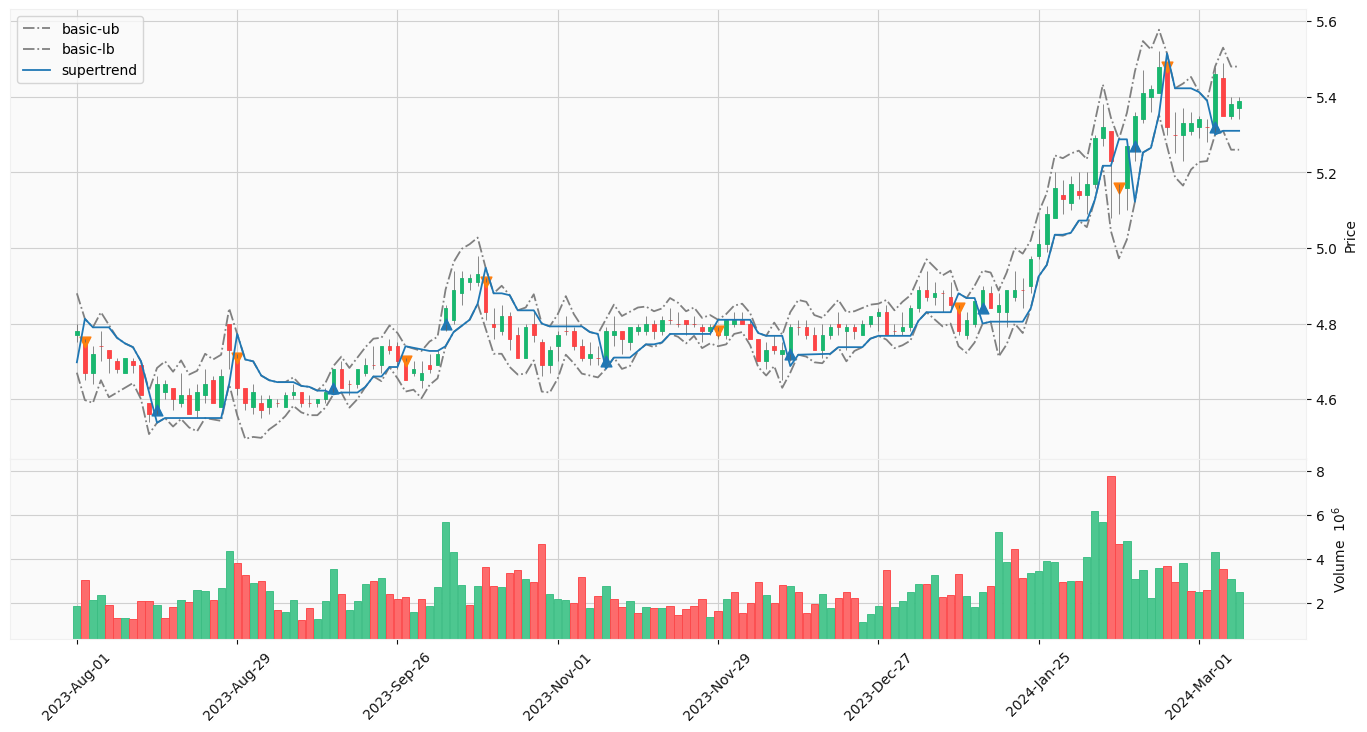

In [101]:
import mplfinance as mpf
from datetime import datetime

df = df.dropna(subset=["basic-ub", "basic-lb"])
df = df[df.index >= datetime(2023, 8, 1)]
print(df)

addplots = [
    mpf.make_addplot(df['basic-ub'], label="basic-ub", linestyle='dashdot', color='grey'),
    mpf.make_addplot(df['basic-lb'], label="basic-lb", linestyle='dashdot', color='grey'),
    # mpf.make_addplot(df['final-ub'], label="final-ub"),
    # mpf.make_addplot(df['final-lb'], label="final-lb"),
    mpf.make_addplot(df['st'], label="supertrend"),
    mpf.make_addplot(df["buy-signal"], type='scatter',markersize=60,marker='^'),
    mpf.make_addplot(df["sell-signal"],type='scatter',markersize=60,marker='v'),
]

# 创建一个subplot，用于绘制蜡烛图
fig, axlist = mpf.plot(
    df, 
    type='candle',
    figsize=(18, 9),
    style="yahoo",
    volume=True,
    addplot=addplots,              # 增加格外的plot 比如我这里加了bollinger线
    show_nontrading=False,
    returnfig=True,
)

# 显示图表
mpf.show()